### Introduction 

**QuDynamics.jl** provides a framework to solve Quantum Mechanics Equations using various solvers like : 

1. **`ode45`, `ode78`, `ode23s`** solvers from _`ODE.jl`_
2. **`expmv`** from _`ExpmV.jl`_, _`Expokit.jl`_
3. Monte Carlo Wavefunction Method
4. Euler, Crank Nicholson, Krylov solver methods.

to solve _Time independent_ and _Time dependent_ 

1. Schrodinger Equation
2. Liouville von Neumann Equation
3. Lindblad Master Equation

----------

The package uses various basic constructs from **QuBase.jl**, the _base_ package which includes all the necessary machinery for quantum physics related operations. **PyPlot.jl** will be used for plotting. Loading all the packages :

In [4]:
using QuBase
using QuDynamics
using PyPlot

---

The following are the _minimum_ **parameters** to define a system :

1. **Hamiltonian** of the system
2. **Initial state** of the system
3. **Time steps** at which the system is evolved

#### Defining the system

<style TYPE="text/css">
code.has-jax {font: inherit; font-size: 100%; background: inherit; border: inherit;}
</style>
<script type="text/x-mathjax-config">
MathJax.Hub.Config({
    tex2jax: {
        inlineMath: [['$','$'], ['\\(','\\)']],
        skipTags: ['script', 'noscript', 'style', 'textarea', 'pre'] // removed 'code' entry
    }
});
MathJax.Hub.Queue(function() {
    var all = MathJax.Hub.getAllJax(), i;
    for(i = 0; i < all.length; i += 1) {
        all[i].SourceElement().parentNode.className += ' has-jax';
    }
});
</script>
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>

Setting up a very basic system by defining the above parameters

Hamiltonian ℋ = σₓ 

Initial State ψ = $\begin{pmatrix}
  1  \\
  0
 \end{pmatrix}$

Time steps = 0. - 2*$\pi$ spaced at 0.01

##### Converting the above data into a suitable format for QuDynamics

In [5]:
ℋ = σₓ;
ψ = statevec(1, FiniteBasis(2));
tₙ = 0.:0.01:2*pi;

Using the above data along with a specific solver from 

* **QuODE45**
* **QuODE78**
* **QuODE23s**
* **QuExpmV**
* **QuExpokit**
* **QuEuler**
* **QuCrankNicolson**
* **QuKrylov**

construct `prop_expmV`. 

_Note_ : **`QuPropagator`** and **`QuStateEvolution`** are equivalent.

In [6]:
prop_expmV = QuPropagator(ℋ, ψ, tₙ, QuExpmV())

Summarizing the system :
Equation type : QuDynamics.QuSchrodingerEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}}
Size of the Hamiltonian of the system : (2,2)
Size of the Initial state : (2,)
Time steps used : 0.0:0.01:6.28
Solver used : QuDynamics.QuExpmV(Dict{Symbol,Any}())


Evolution can be done in the following way,  plotting the evolved states

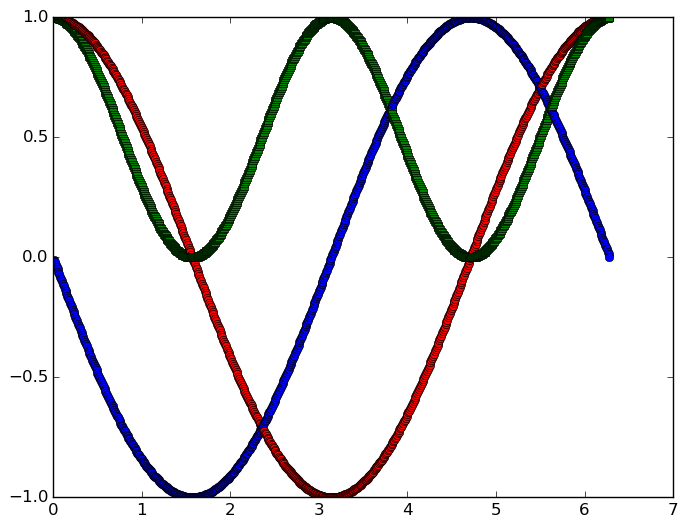

In [7]:
for (t, psi) in prop_expmV
    plot(t, real(coeffs(psi)[1]), "ro")
    plot(t, imag(coeffs(psi)[2]), "bo")
    plot(t, real(expectationvalue(psi, lowerop(2)*lowerop(2)')), "gs")
end

Let's try other solver and see if the result is the same 

In [8]:
prop_ode45 = QuPropagator(ℋ, ψ, tₙ, QuODE45())

Summarizing the system :
Equation type : QuDynamics.QuSchrodingerEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}}}
Size of the Hamiltonian of the system : (2,2)
Size of the Initial state : (2,)
Time steps used : 0.0:0.01:6.28
Solver used : QuDynamics.QuODE45(Dict{Symbol,Any}())


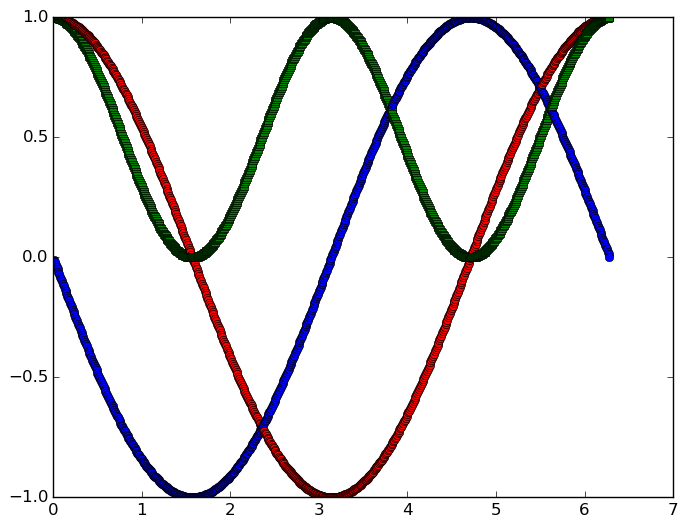

In [10]:
for (t, psi) in prop_ode45
    plot(t, real(coeffs(psi)[1]), "ro")
    plot(t, imag(coeffs(psi)[2]), "bo")
    plot(t, real(expectationvalue(psi, lowerop(2)*lowerop(2)')), "gs")
end

-------------------

**`QuPropagator`** (equivalent to **`QuStateEvolution`**), **`QuPropagatorState`** are the basic types constructs. The iterator methods _**`start` , `next` , `done`**_ are defined for the above type constructs. 

**QuPropagator** ~ **QuStateEvolution** :

```julia
immutable QuStateEvolution{QPM<:QuPropagatorMethod, QVM<:@compat(Union{QuBase.AbstractQuVector,QuBase.AbstractQuMatrix}), QE<:QuEquation}
    eq::QE
    init_state::QVM
    tlist
    method::QPM
    QuStateEvolution(eq, init_state, tlist, method) = new(eq, init_state, tlist, method)
end
```

**QuPropagatorState** :

```julia
immutable QuPropagatorState
    state
    t
    t_state
end
```

**`QuPropagator`** defines the system as seen from the previous example and **`QuPropagatorState`** is the construct which stores the _state evolution_ from time to time. `start` , `next` , `done` look as follows :

```julia
function Base.start(prob::QuStateEvolution)
    init_state = prob.init_state
    t_state = start(prob.tlist)
    t,t_state = next(prob.tlist,t_state)
    return QuPropagatorState(init_state,t,t_state)
end


function Base.next{QPM<:QuPropagatorMethod}(prob::QuStateEvolution{QPM}, qustate::QuPropagatorState)
    current_qustate = qustate.state
    current_t = qustate.t
    t,t_state = next(prob.tlist, qustate.t_state)
    `next_qustate = propagate(prob.method, prob.eq, t, current_t, current_qustate)`
    return (t, next_qustate), QuPropagatorState(next_qustate, t, t_state)
end

Base.done(prob::QuStateEvolution, qustate::QuPropagatorState) = done(prob.tlist, qustate.t_state)
```

**`next`** dispatches to **`propagate`** function which is defined for each _solver_.  

** Propagate for _`expm`_ from _`QuExpmV`_ ** :

```julia
function propagate(prob::QuExpmV, eq::QuEquation, t, current_t, current_qustate)
    dt = t - current_t
    dims = size(current_qustate)
    next_state = ExpmV.expmv(dt, -im*coeffs(operator(eq, t)), coeffs(vec(current_qustate)), M = get(prob.options, :M, []), prec = get(prob.options, :prec, "double"),
                            shift = get(prob.options, :shift, false), full_term = get(prob.options, :full_term, false))
    CQST = QuBase.similar_type(current_qustate)
    return CQST(reshape(next_state, dims), bases(current_qustate))
end
```

Therefore, to add a new solver all that is needed is to define appropriate **`propagate`** function. This [Wiki](https://github.com/JuliaQuantum/QuDynamics.jl/wiki/Adding-a-new-solver-to-QuDynamics-!) explains in more detail on how a sutiable **`propagate`** function can be constructed. Tweaking around a bit, creating a new equation type (for example something similar to `QuSchrodingerEq`), along with a custom _**`operator`**_ function allows to solve the time dependent equations.

-------------------

**QuDynamics** also provides interface to **QuTiP** functions like _`sesolve`_, _`mesolve`_, _`mcsolve`_. For example _`sesolve`_ can be called in the following way which returns the set of evolved states at every time step.

In [13]:
# Loading the QuTiP module in QuDynamics
using QuDynamics.QuTiP

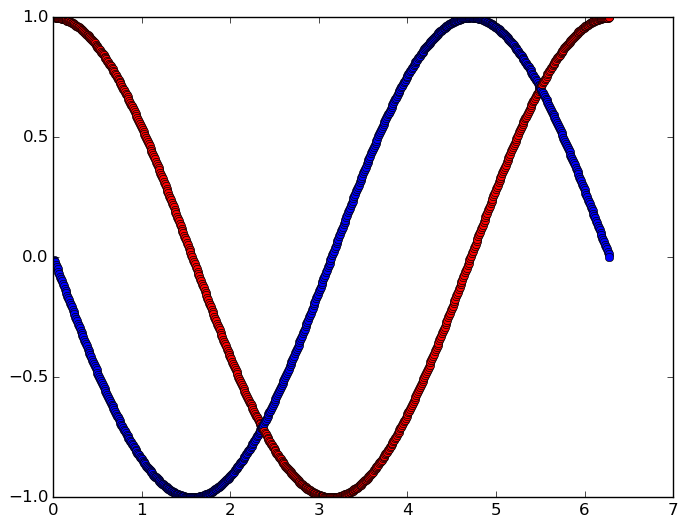

In [14]:
evolution_time, evolved_states = sesolve(ℋ, ψ, tₙ)
# evolution_ti_time, evolved_statesme =  evolution[1]
# evolved_states = evolution[2]
for i in range(1,length(evolution_time))
    plot(evolution_time[i], real(evolved_states[i][1]), "ro")
    plot(evolution_time[i], imag(evolved_states[i][2]), "bo")
end

---

To conclude we look at **Monte Carlo Solver**, _**`QuMCWF()`**_ which is a bit different from the conventional setting we have seen till now. This would also help shed some light on how parallelization can be brought in at different levels of design.

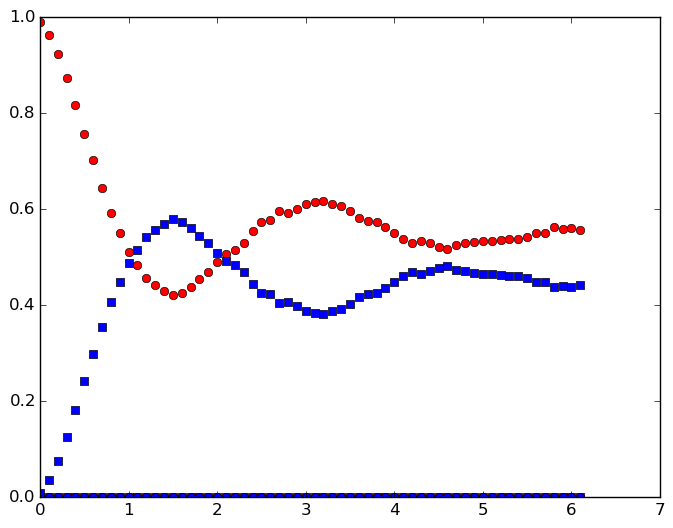

In [15]:
tₙ = 0.:0.1:2*π
ρ = complex(ψ*ψ')
ρₛ =  Array(typeof(ρ), length(tₙ)-1)
qumcwfen = QuMCWFEnsemble(complex(ρ), 1000)
for i=1:length(tₙ)-1
    ρₛ[i] = complex(zeros(ρ))
end
for psi0 in qumcwfen
    i = 1
    mcwf = QuMCWF()
    for (t,psi) in QuStateEvolution(ℋ, [lowerop(2)], psi0, tₙ, mcwf)
        ρₛ[i] = ρₛ[i] + (psi*psi')/length(qumcwfen)/norm(psi)^2
        i = i + 1
    end
end
for index in range(1, length(tₙ)-1)
    plot(tₙ[index], coeffs(ρₛ[index])[1,1], "ro")
    plot(tₙ[index], coeffs(ρₛ[index])[1,2], "rs")
    plot(tₙ[index], coeffs(ρₛ[index])[2,1], "bo")
    plot(tₙ[index], coeffs(ρₛ[index])[2,2], "bs")
end

The parallelization of the above has been implemented [here](http://juliaquantum.github.io/news/2015/08/GSoC2015-Wrap-up-and-Outlook). Parallelizations can be achieved at other different levels of abstraction for example parallelization of **`QuArray`** from **`QuBase`** would facilitate efficient and faster computation of not only the evolution as well other functionalities of other libraries which are based on **`QuBase`**. 

-------

#### More Examples using different system parameters (given additional time)

Using density matrix formulation for the above system results in Liouville von Neumann Equation. Using the same formulation as above :

In [9]:
qprop_lvn = QuPropagator(ℋ, ψ*ψ', tₙ, QuODE45())

Summarizing the system :
Equation type : QuDynamics.QuLiouvillevonNeumannEq{QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}}}
Size of the Liouvillian of the system : (4,4)
Size of the Density matrix : (2,2)
Time steps used : 0.0:0.01:6.28
Solver used : QuDynamics.QuODE45(Dict{Symbol,Any}())


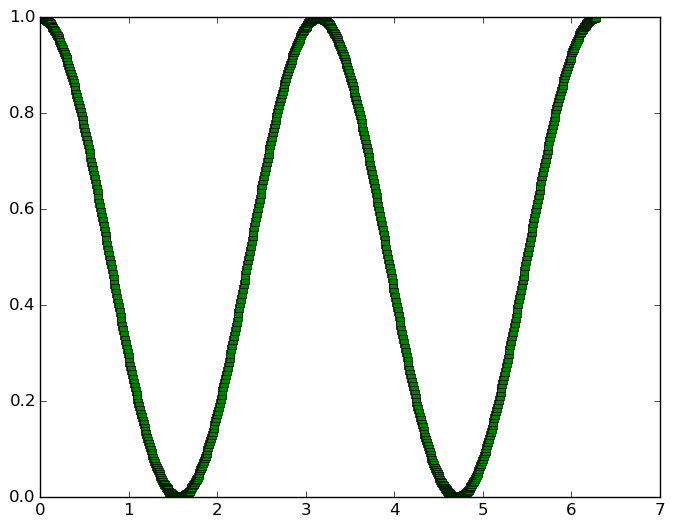

In [10]:
for (t, ψₘ) in  qprop_lvn
    plot(t, expectationvalue(ψₘ, lowerop(2)*lowerop(2)'), "gs")
end

---

A more realistic system would involve influence of the environment whose information is captured by the action of the collapse operators on the Hamiltonian. Consider the following toy model :

In [11]:
ℋₛ = σₓ;
ψ = statevec(1, FiniteBasis(2));
ρ = ψ*ψ';
tlist = 0.:0.01:2*π;
𝓒 = [lowerop(2)];

In [12]:
qme = QuPropagator(ℋₛ, 𝓒, ρ,  tlist, QuExpmV())

Summarizing the system :
Equation type : QuDynamics.QuLindbladMasterEq{1,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,SparseMatrixCSC{Float64,Int64}}}
Size of the Lindblad operator of the system : (4,4)
Size of the Hamiltonian of the system : (2,2)
Number of collapse operators : 1
Size of the Density matrix : (2,2)
Time steps used : 0.0:0.01:6.28
Solver used : QuDynamics.QuExpmV(Dict{Symbol,Any}())


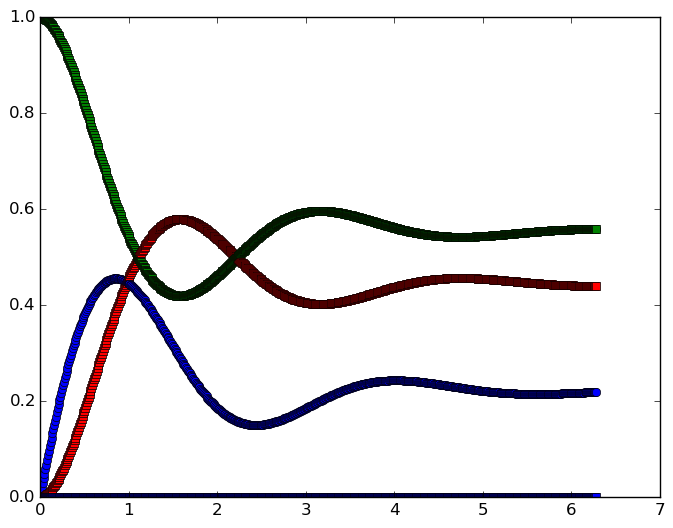

In [13]:
for (t, ρₙ) in qme
    plot(t, real(coeffs(ρₙ)[1,1]), "ro")
    plot(t, real(coeffs(ρₙ)[2,2]), "rs")
    plot(t, imag(coeffs(ρₙ)[1,2]), "bo")
    plot(t, imag(coeffs(ρₙ)[2,2]), "bs")
    plot(t, expectationvalue(ρₙ, lowerop(2)*lowerop(2)'), "gs")
end

---

##### More  realistic example - Jaynes Cummings Model

In [14]:
function jc_setup(N, wc, wa, g, kappa, gamma, use_rwa)
    # Hamiltonian
    idc = QuArray(eye(N))
    ida = QuArray(eye(2))
    a  = tensor(lowerop(N), ida)
    sm = tensor(idc, lowerop(2))
    if use_rwa
        # use the rotating wave approxiation
        H = wc * a' * a + wa * sm' * sm + g * (a' * sm + a * sm')
    else
        H = wc * a' * a + wa * sm' * sm + g * (a' + a) * (sm + sm')
    end
    # collapse operators
    c_op_list = Array(QuBase.AbstractQuMatrix, 0)
    n_th_a = 0.0
    rate = kappa * (1 + n_th_a)
    if rate > 0.0
       push!(c_op_list, full(sqrt(rate) * a))
    end
    rate = kappa * n_th_a
    if rate > 0.0
        push!(c_op_list, full(sqrt(rate) * a'))
    end
    rate = gamma
    if rate > 0.0
        push!(c_op_list, full(sqrt(rate) * sm))
    end
    return full(H), c_op_list
end

jc_setup (generic function with 1 method)

In [15]:
# parameters
wc = 1.0 * 2 * pi;   # cavity frequency
wa = 1.0 * 2 * pi;   # atom frequency
g  = 0.05 * 2 * pi;  # coupling strength
kappa = 0.05;        # cavity dissipation rate
gamma = 0.15;       # atom dissipation rate
N = 2;           # number of cavity fock states
use_rwa = true;

In [16]:
# Hamiltonian, collapse operators
H, c_ops = jc_setup(N, wc, wa, g, kappa, gamma, use_rwa);

# initial state
psi0 = complex(tensor(statevec(1, FiniteBasis(N)), statevec(2, FiniteBasis(2))));

# time steps
tlist = 0.:0.001:2*pi;

In [17]:
# setting up the system using a solver
qprop = QuPropagator(H, c_ops, psi0*psi0', tlist, QuODE45())

Summarizing the system :
Equation type : QuDynamics.QuLindbladMasterEq{1,QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Complex{Float64},2,SparseMatrixCSC{Complex{Float64},Int64}},QuBase.QuArray{QuBase.FiniteBasis{QuBase.Orthonormal},Float64,2,Array{Float64,2}},QuBase.AbstractQuArray{B<:QuBase.AbstractBasis{S<:QuBase.AbstractStructure},T,2}}
Size of the Lindblad operator of the system : (16,16)
Size of the Hamiltonian of the system : (4,4)
Number of collapse operators : 2
Size of the Density matrix : (4,4)
Time steps used : 0.0:0.001:6.283
Solver used : QuDynamics.QuODE45(Dict{Symbol,Any}())


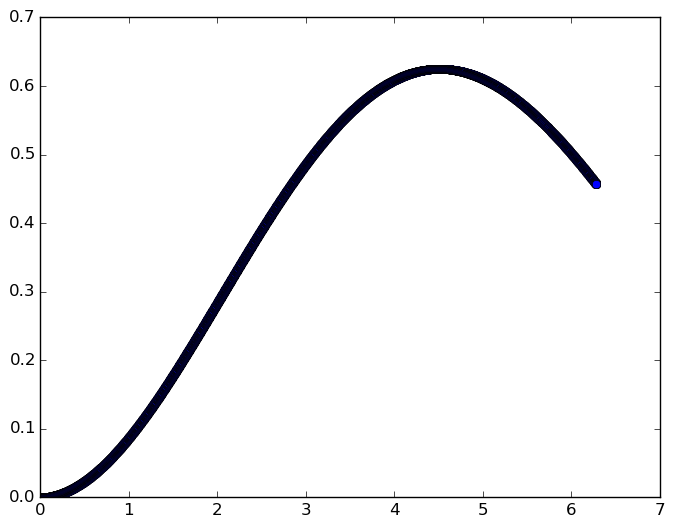

In [18]:
# Calculating the expectation values for observable a'*a
a = tensor(lowerop(2), QuArray(eye(2)))
op = a'*a
for (t, ρₘ) in  qprop
    plot(t, expectationvalue(ρₘ, op), "bo")
end

----